In [1]:
import xarray as xr
import os
import pandas as pd
import numpy as np
import functions.eddy_feedback as ef

import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

# Calculating EFPs for CSV file

In [2]:
# data_path = '/home/links/ct715/data_storage/PAMIP/processed_daily/daily_efp_mon-avg'
# models = sorted(os.listdir(data_path))

# ds = {}
# for model in models:
    
#     path = os.path.join(data_path, model)
#     files = os.path.join(path, '*.nc')
#     if len(files) == 0:
#         print(f'No files found for {model}')
#         continue
#     ds[model] = xr.open_mfdataset(files, concat_dim='ens_ax', combine='nested')
    
# efp_data = []

# for model in models:
#     dataset = ds[model]
    
#     if model == 'HadGEM3-GC31-LL':
#         members = np.delete(dataset.ens_ax.values, [27,28])    # <------- REMOVED FROM STORE
#         dataset=dataset.sel(ens_ax=members)
    
#     efp_nh = ef.calculate_efp(dataset, data_type='pamip', calc_south_hemis=False)
#     efp_sh = ef.calculate_efp(dataset, data_type='pamip', calc_south_hemis=True)
    
#     efp_data.append({'model': model, 'efp_nh': efp_nh, 'efp_sh': efp_sh})

# efp_df = pd.DataFrame(efp_data)

# efp_df.to_csv('./data/daily_efp_8models.csv')
    

See this [Notebook](/home/links/ct715/eddy_feedback/chapter1/efp_random/check_data/HadGEM3_daily_efp.ipynb) for data manipulation of certain models.

# Daily EFP

EFP values calculated using EP fluxes which are calculated using daily u,v.

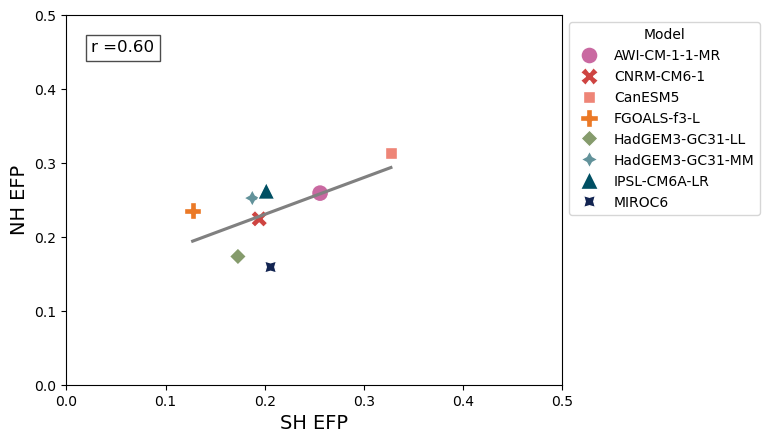

In [3]:
efp_df = pd.read_csv('./data/daily_efp_8models.csv', index_col=0)

# colours
from pypalettes import load_cmap
cmap = load_cmap("Cross")
models = efp_df['model'].unique()
colors = [cmap(i / (len(models) - 1)) for i in range(len(models))]
palette = dict(zip(models, colors))

sns.regplot(data=efp_df, x='efp_sh', y='efp_nh', scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None)
sns.scatterplot(data=efp_df, x='efp_sh', y='efp_nh', hue='model', style='model', s=150, palette=palette)

# Insert Pearson's correlation
r, p = sp.stats.pearsonr(x=efp_df['efp_nh'], y=efp_df['efp_sh'])
ax = plt.gca()
plt.text(.05, .9, "r ={:.2f}".format(r), transform=ax.transAxes, 
         bbox=dict(facecolor="white", alpha=0.7), fontsize=12)

plt.ylabel('NH EFP', fontsize=14)
plt.xlabel('SH EFP', fontsize=14)
# plt.title('500 hPa EFP', fontsize=16)
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)

plt.legend(bbox_to_anchor=(1,1), title='Model')
plt.show()

## Compare with reanalysis

In [4]:
# # Uncomment the following lines to calculate EFP for JRA55 reanalysis data
# jra_path = '/home/links/ct715/data_storage/reanalysis/jra55_daily'
# ds = xr.open_mfdataset(f'{jra_path}/jra55_uvtw_ubar_ep.nc')
# nh_efp = ef.calculate_efp(ds, data_type='reanalysis', which_div1='div1')
# sh_efp = ef.calculate_efp(ds, data_type='reanalysis', which_div1='div1', calc_south_hemis=True)
# efp_df.loc[len(efp_df)] = ["JRA55", nh_efp, sh_efp]
# efp_df.to_csv('./data/daily_efp_8models+jra55.csv')

# Load data and separate JRA55
pamip = pd.read_csv('./data/daily_efp_8models+jra55.csv', index_col=0)
jra = pamip[pamip['model'] == 'JRA55'].copy().reset_index(drop=True)
pamip = pamip.drop(8)
pamip

,model,efp_nh,efp_sh
0,AWI-CM-1-1-MR,0.2592,0.2557
1,CNRM-CM6-1,0.2244,0.1944
2,CanESM5,0.3133,0.3271
3,FGOALS-f3-L,0.2353,0.1273
4,HadGEM3-GC31-LL,0.1735,0.1729
5,HadGEM3-GC31-MM,0.2525,0.1874
6,IPSL-CM6A-LR,0.2623,0.2015
7,MIROC6,0.1592,0.2058


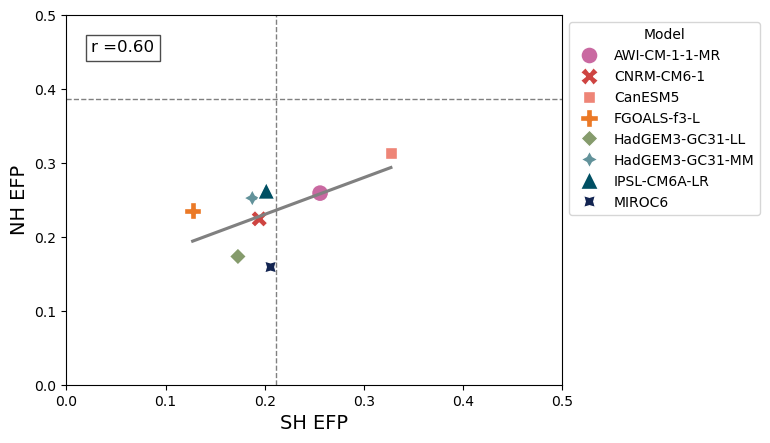

In [5]:
sns.regplot(data=pamip, x='efp_sh', y='efp_nh', scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None)
sns.scatterplot(data=pamip, x='efp_sh', y='efp_nh', hue='model', style='model', s=150, palette=palette)

# Insert Pearson's correlation
r, p = sp.stats.pearsonr(x=pamip['efp_nh'], y=pamip['efp_sh'])
ax = plt.gca()
plt.text(.05, .9, "r ={:.2f}".format(r), transform=ax.transAxes, 
         bbox=dict(facecolor="white", alpha=0.7), fontsize=12)

plt.ylabel('NH EFP', fontsize=14)
plt.xlabel('SH EFP', fontsize=14)
# plt.title('500 hPa EFP', fontsize=16)
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)

plt.axvline(jra['efp_sh'].values[0], color='gray', linestyle='--', linewidth=1)
plt.axhline(jra['efp_nh'].values[0], color='gray', linestyle='--', linewidth=1)

plt.legend(bbox_to_anchor=(1,1), title='Model')
# plt.savefig('./plots/500hPa_efp_NH_vs_SH.png')
plt.show()

# Compare with original EFP data

In [6]:
# Import original EFP data for comparison
og_efp = pd.read_csv('./data/non-regridded_efp.csv', index_col=0)
og_efp_matched = og_efp[og_efp['model'].isin(efp_df['model'])].reset_index(drop=True)

# fabricate and add AWI into the dataframe
og_efp_matched.loc[len(og_efp_matched)] = ["AWI-CM-1-1-MR", 0.3724, 0.4354]
og_efp_matched = og_efp_matched.sort_values(by='model').reset_index(drop=True)

# Calculate EFP for JRA55 reanalysis data using SRIP dataset
og_jra_path = '/home/links/ct715/data_storage/reanalysis/srip_datasets'
og_ds = xr.open_mfdataset(f'{og_jra_path}/JRA55_srip_ubar_div1.nc')
og_nh_efp = ef.calculate_efp(og_ds, data_type='reanalysis', which_div1='div1_pr')
og_sh_efp = ef.calculate_efp(og_ds, data_type='reanalysis', which_div1='div1_pr', calc_south_hemis=True)
og_efp_matched.loc[len(og_efp_matched)] = ["JRA55", og_nh_efp, og_sh_efp]

# Separate JRA55 from the rest of the dataframe
og_jra_efp = og_efp_matched[og_efp_matched['model'] == 'JRA55'].copy().reset_index(drop=True)
og_efp_matched = og_efp_matched.drop(8)

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


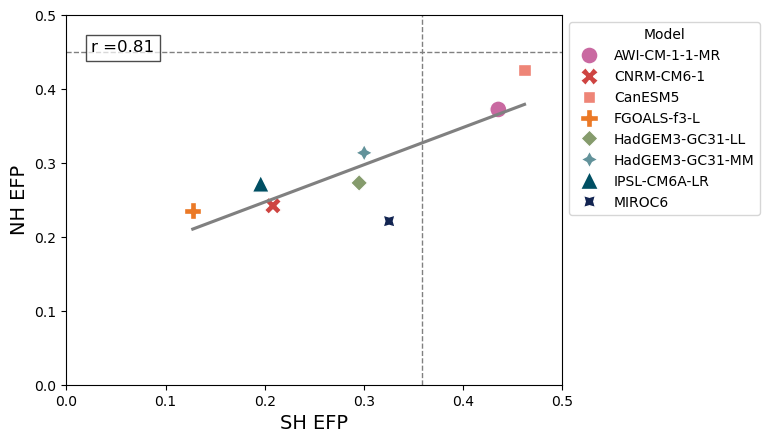

In [7]:
sns.regplot(data=og_efp_matched, x='efp_sh', y='efp_nh', scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None)
sns.scatterplot(data=og_efp_matched, x='efp_sh', y='efp_nh', hue='model', style='model', s=150, palette=palette)

# Insert Pearson's correlation
r, p = sp.stats.pearsonr(x=og_efp_matched['efp_nh'], y=og_efp_matched['efp_sh'])
ax = plt.gca()
plt.text(.05, .9, "r ={:.2f}".format(r), transform=ax.transAxes, 
         bbox=dict(facecolor="white", alpha=0.7), fontsize=12)

plt.ylabel('NH EFP', fontsize=14)
plt.xlabel('SH EFP', fontsize=14)
# plt.title('500 hPa EFP', fontsize=16)
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)

plt.axvline(og_jra_efp['efp_sh'].values[0], color='gray', linestyle='--', linewidth=1)
plt.axhline(og_jra_efp['efp_nh'].values[0], color='gray', linestyle='--', linewidth=1)

plt.legend(bbox_to_anchor=(1,1), title='Model')
# plt.savefig('./plots/500hPa_efp_NH_vs_SH.png')
plt.show()

## Comparing on the same figure

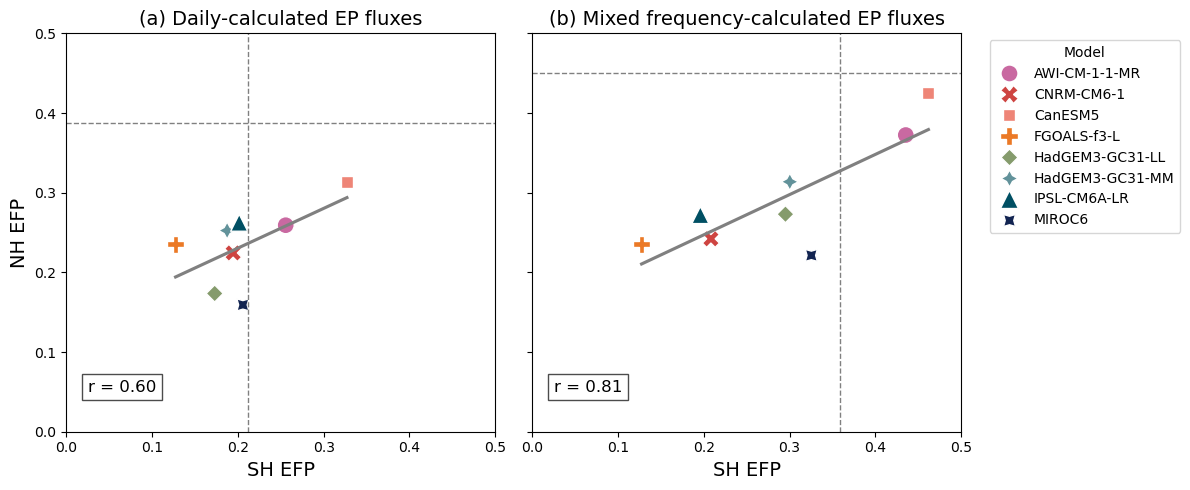

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Panel (a)
sns.regplot(ax=axes[0], data=pamip, x='efp_sh', y='efp_nh',
            scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None)
sns.scatterplot(ax=axes[0], data=pamip, x='efp_sh', y='efp_nh',
                hue='model', style='model', s=150, palette=palette)

r, _ = sp.stats.pearsonr(x=pamip['efp_nh'], y=pamip['efp_sh'])
axes[0].text(0.05, 0.1, f"r = {r:.2f}", transform=axes[0].transAxes,
             bbox=dict(facecolor="white", alpha=0.7), fontsize=12)

axes[0].set_xlabel('SH EFP', fontsize=14)
axes[0].set_ylabel('NH EFP', fontsize=14)
axes[0].set_xlim(0, 0.5)
axes[0].set_ylim(0, 0.5)
axes[0].axvline(jra['efp_sh'].values[0], color='gray', linestyle='--', linewidth=1)
axes[0].axhline(jra['efp_nh'].values[0], color='gray', linestyle='--', linewidth=1)
axes[0].set_title('(a) Daily-calculated EP fluxes', fontsize=14)
axes[0].legend_.remove()

# Panel (b)
sns.regplot(ax=axes[1], data=og_efp_matched, x='efp_sh', y='efp_nh',
            scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None)
sns.scatterplot(ax=axes[1], data=og_efp_matched, x='efp_sh', y='efp_nh',
                hue='model', style='model', s=150, palette=palette)

r, _ = sp.stats.pearsonr(x=og_efp_matched['efp_nh'], y=og_efp_matched['efp_sh'])
axes[1].text(0.05, 0.1, f"r = {r:.2f}", transform=axes[1].transAxes,
             bbox=dict(facecolor="white", alpha=0.7), fontsize=12)

axes[1].set_xlabel('SH EFP', fontsize=14)
axes[1].set_ylabel('')  # Y-axis label only on left
axes[1].set_xlim(0, 0.5)
axes[1].set_ylim(0, 0.5)
axes[1].axvline(og_jra_efp['efp_sh'].values[0], color='gray', linestyle='--', linewidth=1)
axes[1].axhline(og_jra_efp['efp_nh'].values[0], color='gray', linestyle='--', linewidth=1)
axes[1].set_title('(b) Mixed frequency-calculated EP fluxes', fontsize=14)

# Move legend outside the second panel
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Model')

plt.tight_layout()
plt.show()


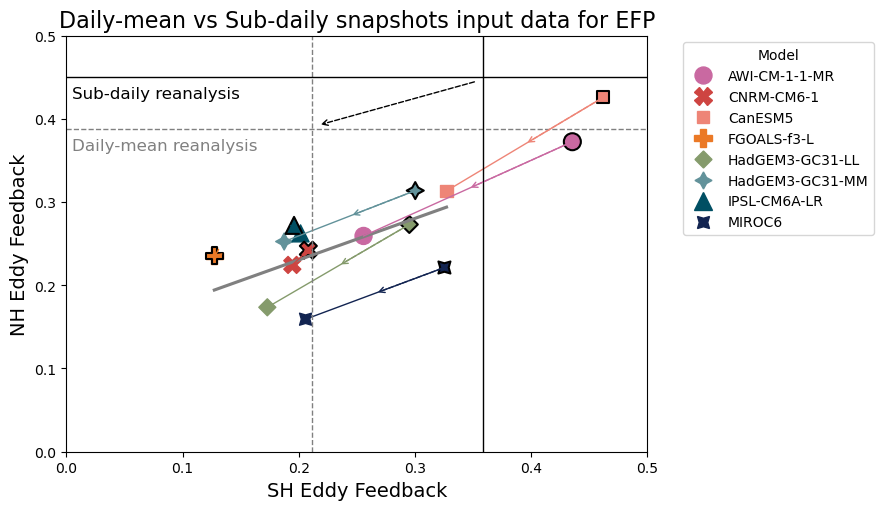

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

plt.figure(figsize=(9,5))

# Plot regression line for pamip
sns.regplot(data=pamip, x='efp_sh', y='efp_nh',
            scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None)

# Plot pamip points
scatter1 = sns.scatterplot(data=pamip, x='efp_sh', y='efp_nh',
                           hue='model', style='model', s=150, palette=palette, edgecolor=None)

# Plot og_efp_matched points with black outline
sns.scatterplot(data=og_efp_matched, x='efp_sh', y='efp_nh',
                hue='model', style='model', s=150, palette=palette,
                edgecolor="black", linewidth=1.5, legend=False)

# Draw dashed arrows between matching models
for model in pamip['model'].unique():
    pamip_row = pamip[pamip['model'] == model]
    og_row = og_efp_matched[og_efp_matched['model'] == model]
    
    if not pamip_row.empty and not og_row.empty:
        x_start = og_row['efp_sh'].values[0]
        x_end = pamip_row['efp_sh'].values[0]
        y_start = og_row['efp_nh'].values[0]
        y_end = pamip_row['efp_nh'].values[0]
        
        # Original dashed line
        plt.plot([x_start, x_end], [y_start, y_end],
                 linestyle='-', color=palette[model], linewidth=1)
        
        # Midpoint for short arrow
        x_mid = x_start + (x_end - x_start) * 0.5
        y_mid = y_start + (y_end - y_start) * 0.5
        
        # Arrow from midpoint to og_row (i.e., pointing toward pamip)
        plt.annotate(
            '',
            xy=(x_mid, y_mid), xytext=(x_start, y_start),
            arrowprops=dict(
                arrowstyle='->', linestyle='--',
                color=palette[model], linewidth=1
            )
        )
        
# Arrow from sub-daily EFP to daily EFP
x_start, y_start = og_jra_efp['efp_sh'].values[0], og_jra_efp['efp_nh'].values[0]
x_end, y_end = jra['efp_sh'].values[0], jra['efp_nh'].values[0]
move = 0.005

plt.annotate(
    '',
    xy=(x_end + move, y_end + move),
    xytext=(x_start - move, y_start - move),
    arrowprops=dict(
        arrowstyle='->',
        linestyle='--',
        color='k',
        linewidth=1
    )
)



# Axis and reference lines
plt.xlabel('SH Eddy Feedback', fontsize=14)
plt.ylabel('NH Eddy Feedback', fontsize=14)
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)

# Daily EFP reference lines
plt.axvline(jra['efp_sh'].values[0], color='gray', linewidth=1, linestyle='--')
plt.axhline(jra['efp_nh'].values[0], color='gray', linewidth=1, linestyle='--')
r, _ = sp.stats.pearsonr(x=pamip['efp_nh'], y=pamip['efp_sh'])
plt.text(0.005, jra['efp_nh'].values[0] - 0.025, f'Daily-mean reanalysis' , color='gray', fontsize=12)
# plt.text(0.005, jra['efp_nh'].values[0] - 0.025, f'Daily-mean EFP (r={r:.2f})' , color='gray', fontsize=12)

# Mixed frequency EFP reference lines
plt.axvline(og_jra_efp['efp_sh'].values[0], color='k', linewidth=1)
plt.axhline(og_jra_efp['efp_nh'].values[0], color='k', linewidth=1)
r, _ = sp.stats.pearsonr(x=og_efp_matched['efp_nh'], y=og_efp_matched['efp_sh'])
plt.text(0.005, og_jra_efp['efp_nh'].values[0] - 0.025, f'Sub-daily reanalysis' , color='k', fontsize=12)
# plt.text(0.005, og_jra_efp['efp_nh'].values[0] - 0.025, f'Sub-daily EFP (r={r:.2f})' , color='k', fontsize=12)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Model')
plt.tight_layout()

plt.title(f'Daily-mean vs Sub-daily snapshots input data for EFP', fontsize=16)
plt.savefig('./plots/daily_vs_sub-daily_efp', bbox_inches='tight')
plt.show()


# Poster making

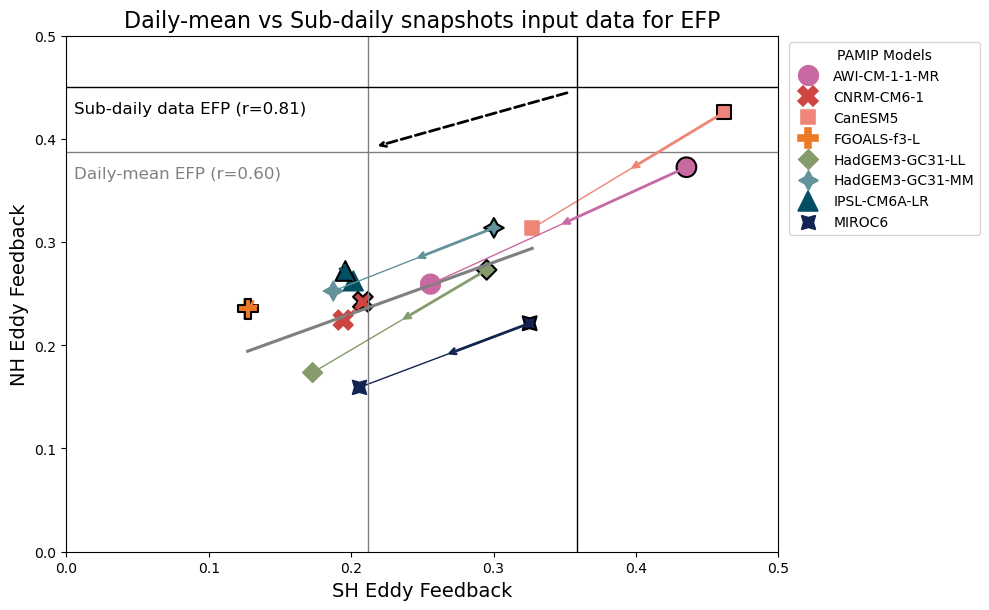

In [12]:
def mm_to_inches(mm):
    return mm / 25.4

# Example usage:
width_mm = 200  # e.g., full-page width in a journal
height_mm = 150

# figsize = (mm_to_inches(width_mm*2), mm_to_inches(height_mm*2))
figsize = (10,6)
plt.figure(figsize=figsize)

# Plot regression line for pamip
sns.regplot(data=pamip, x='efp_sh', y='efp_nh',
            scatter_kws={'color': 'white'}, line_kws={"color": "gray"}, ci=None)

# Plot pamip points
scatter1 = sns.scatterplot(data=pamip, x='efp_sh', y='efp_nh',
                           hue='model', style='model', s=200, palette=palette, edgecolor=None)

# Plot og_efp_matched points with black outline
sns.scatterplot(data=og_efp_matched, x='efp_sh', y='efp_nh',
                hue='model', style='model', s=200, palette=palette,
                edgecolor="black", linewidth=1.5, legend=False)

# Draw dashed arrows between matching models
for model in pamip['model'].unique():
    pamip_row = pamip[pamip['model'] == model]
    og_row = og_efp_matched[og_efp_matched['model'] == model]
    
    if not pamip_row.empty and not og_row.empty:
        x_start = og_row['efp_sh'].values[0]
        x_end = pamip_row['efp_sh'].values[0]
        y_start = og_row['efp_nh'].values[0]
        y_end = pamip_row['efp_nh'].values[0]
        
        # Original dashed line
        plt.plot([x_start, x_end], [y_start, y_end],
                 linestyle='-', color=palette[model], linewidth=1)
        
        # Midpoint for short arrow
        x_mid = x_start + (x_end - x_start) * 0.5
        y_mid = y_start + (y_end - y_start) * 0.5
        
        # Arrow from midpoint to og_row (i.e., pointing toward pamip)
        plt.annotate(
            '',
            xy=(x_mid, y_mid), xytext=(x_start, y_start),
            arrowprops=dict(
                arrowstyle='->', linestyle='-',
                color=palette[model], linewidth=2
            )
        )
        
# Arrow from sub-daily EFP to daily EFP
x_start, y_start = og_jra_efp['efp_sh'].values[0], og_jra_efp['efp_nh'].values[0]
x_end, y_end = jra['efp_sh'].values[0], jra['efp_nh'].values[0]
move = 0.005

plt.annotate(
    '',
    xy=(x_end + move, y_end + move),
    xytext=(x_start - move, y_start - move),
    arrowprops=dict(
        arrowstyle='->',
        linestyle='--',
        color='k',
        linewidth=2
    )
)



# Axis and reference lines
plt.xlabel('SH Eddy Feedback', fontsize=14)
plt.ylabel('NH Eddy Feedback', fontsize=14)
plt.ylim(0, 0.5)
plt.xlim(0, 0.5)

# Daily EFP reference lines
plt.axvline(jra['efp_sh'].values[0], color='gray', linewidth=1)
plt.axhline(jra['efp_nh'].values[0], color='gray', linewidth=1)
r, _ = sp.stats.pearsonr(x=pamip['efp_nh'], y=pamip['efp_sh'])
plt.text(0.005, jra['efp_nh'].values[0] - 0.025, f'Daily-mean EFP (r={r:.2f})' , color='gray', fontsize=12)

# Mixed frequency EFP reference lines
plt.axvline(og_jra_efp['efp_sh'].values[0], color='k', linewidth=1)
plt.axhline(og_jra_efp['efp_nh'].values[0], color='k', linewidth=1)
r, _ = sp.stats.pearsonr(x=og_efp_matched['efp_nh'], y=og_efp_matched['efp_sh'])
plt.text(0.005, og_jra_efp['efp_nh'].values[0] - 0.025, f'Sub-daily data EFP (r={r:.2f})' , color='k', fontsize=12)

plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', title='PAMIP Models')
plt.tight_layout()

plt.title(f'Daily-mean vs Sub-daily snapshots input data for EFP', fontsize=16)
plt.savefig('./plots/poster-dims_daily_vs_sub-daily_efp', bbox_inches='tight')
plt.show()